In [1]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
# загрузим датасет со своего Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
books = pd.read_csv('drive/MyDrive/Netology/Books.csv')
ratings = pd.read_csv('drive/MyDrive/Netology/Ratings.csv')

In [6]:
books_with_ratings = books.merge(ratings, on='ISBN').reset_index(drop=True)
books_with_ratings.dropna(inplace=True)

In [7]:
df = books_with_ratings[['ISBN','Book-Title', 'Book-Author', 'User-ID', 'Book-Rating']]
df.rename(columns={'ISBN':'isbn','Book-Title': 'title','Book-Author': 'author', 'User-ID': 'user','Book-Rating':'rating'}, inplace=True)

In [8]:
df1 = df[df['rating'] >= 5]

In [9]:
df1.shape

(367246, 5)

In [10]:
df1['combined'] = df1[['title','author']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [11]:
lf = LabelEncoder()
df1['book_id'] = lf.fit_transform(df1['combined'])
df1['user_id'] = lf.fit_transform(df1['user'])

In [12]:
df1.head()

,isbn,title,author,user,rating,combined,book_id,user_id
1,0002005018,Clara Callan,Richard Bruce Wright,8,5,Clara Callan_Richard Bruce Wright,20302,0
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8,Clara Callan_Richard Bruce Wright,20302,2618
5,0002005018,Clara Callan,Richard Bruce Wright,67544,8,Clara Callan_Richard Bruce Wright,20302,16078
8,0002005018,Clara Callan,Richard Bruce Wright,116866,9,Clara Callan_Richard Bruce Wright,20302,27729
9,0002005018,Clara Callan,Richard Bruce Wright,123629,9,Clara Callan_Richard Bruce Wright,20302,29305


In [13]:
book_rating_count = df1.groupby('book_id')['rating'].count()
books_10 = book_rating_count[book_rating_count > 10].index
df2 = df1[df1['book_id'].isin(books_10)]

In [14]:
user_rating_count = df2.groupby('user_id')['rating'].count()
users_10 = user_rating_count[user_rating_count > 10].index
df2 = df2[df2['user_id'].isin(users_10)]
df2 = df2[['book_id', 'user_id']]

In [15]:
df2.head()

,book_id,user_id
31,108589,2618
32,108589,6822
34,108589,11051
42,108589,35313
54,108589,54367


In [16]:
df2.shape

(67641, 2)

In [17]:
df2['book_id'].nunique()

4690

In [18]:
df2['user_id'].nunique()

2380

In [19]:
config = {
    'max_len' : 50,
    'hidden_units' : 256, # Embedding size
    'num_heads' : 2, # Multi-head layer
    'num_layers': 2, # block (encoder layer)
    'dropout_rate' : 0.1, # dropout
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 50,
    'num_workers' : 2,
    'mask_prob' : 0.15, # for cloze task
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [21]:
class MakeSequenceDataSet():
    """
    SequenceData
    """
    def __init__(self, config):
        self.df = df2

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('book_id')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user_id')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['book_id'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['user_id'].apply(lambda x : self.user_encoder[x])
        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder

        Args:
            col (str): columns
        Returns:
            dict: user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    def generate_sequence_data(self) -> dict:
        """
        sequence_data

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())

        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]] #

        return user_train, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [22]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        return self.num_user

    def __getitem__(self, user):

        user_seq = self.user_train[user]
        tokens = []
        labels = []
        for s in user_seq[-self.max_len:]:
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1)  # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                elif prob < 0.9:
                    # noise
                    tokens.extend(self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1))  # item random sampling
                else:
                    tokens.append(s)
                labels.append(s) # O
            else:
                tokens.append(s)
                labels.append(0) # X

        mask_len = self.max_len - len(tokens)
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples

In [23]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

In [24]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, max_len, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

In [25]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [26]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

In [27]:
class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [28]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

In [29]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [30]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [31]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [32]:
class BERT(nn.Module):
    def __init__(self, bert_max_len, num_items, bert_num_blocks, bert_num_heads,
                 bert_hidden_units, bert_dropout):
        super().__init__()

        max_len = bert_max_len
        num_items = num_items
        n_layers = bert_num_blocks
        heads = bert_num_heads
        vocab_size = num_items + 2
        hidden = bert_hidden_units
        self.hidden = hidden
        dropout = bert_dropout

        # embedding for BERT, sum of positional, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])
        self.out = nn.Linear(hidden, num_items + 1)

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.out(x)
        return x

    def init_weights(self):
        pass


In [33]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    for seq, labels in tqdm(data_loader):
        seq, labels = seq.to(device), labels.to(device)
        logits = model(seq) # (bs, t, vocab)
        logits = logits.view(-1, logits.size(-1)) # (bs * t, vocab)
        labels = labels.view(-1) # (bs * t)

        optimizer.zero_grad()
        loss = criterion(logits, labels)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

In [34]:
make_sequence_dataset = MakeSequenceDataSet(config)

In [35]:
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [36]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train,
    max_len = config['max_len'],
    num_user = make_sequence_dataset.num_user,
    num_item = make_sequence_dataset.num_item,
    mask_prob = config['mask_prob'],)

In [37]:
data_loader = DataLoader(
    bert4rec_dataset,
    batch_size = config['batch_size'],
    shuffle = True,
    pin_memory = True,
    num_workers = config['num_workers'],)

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BERT(
    num_items = 4690,
    bert_hidden_units = config['hidden_units'],
    bert_num_heads = config['num_heads'],
    bert_num_blocks = config['num_layers'],
    bert_max_len = config['max_len'],
    bert_dropout = config['dropout_rate'],
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # label (padding)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

In [ ]:
for epoch in tqdm(range(1, config['num_epochs'] + 1)):
    train_loss = train(
        model = model,
        criterion = criterion,
        optimizer = optimizer,
        data_loader = data_loader)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}')


  2%|▏         | 1/50 [00:03<02:40,  3.27s/it]

Epoch:   1| Train loss: 8.71328



  4%|▍         | 2/50 [00:04<01:39,  2.07s/it]

Epoch:   2| Train loss: 8.38237



  6%|▌         | 3/50 [00:05<01:20,  1.70s/it]

Epoch:   3| Train loss: 8.20450



  8%|▊         | 4/50 [00:07<01:16,  1.66s/it]

Epoch:   4| Train loss: 8.05579



 10%|█         | 5/50 [00:08<01:08,  1.51s/it]

Epoch:   5| Train loss: 7.92136



 12%|█▏        | 6/50 [00:09<00:59,  1.34s/it]

Epoch:   6| Train loss: 7.78957



 14%|█▍        | 7/50 [00:10<00:53,  1.24s/it]

Epoch:   7| Train loss: 7.70525



 16%|█▌        | 8/50 [00:11<00:48,  1.17s/it]

Epoch:   8| Train loss: 7.63299



 18%|█▊        | 9/50 [00:12<00:45,  1.12s/it]

Epoch:   9| Train loss: 7.52765



 20%|██        | 10/50 [00:13<00:43,  1.09s/it]

Epoch:  10| Train loss: 7.42921



 22%|██▏       | 11/50 [00:14<00:41,  1.06s/it]

Epoch:  11| Train loss: 7.34566



 24%|██▍       | 12/50 [00:15<00:39,  1.05s/it]

Epoch:  12| Train loss: 7.27410



 26%|██▌       | 13/50 [00:16<00:38,  1.04s/it]

Epoch:  13| Train loss: 7.19097



 28%|██▊       | 14/50 [00:17<00:37,  1.04s/it]

Epoch:  14| Train loss: 7.15469



 30%|███       | 15/50 [00:18<00:37,  1.06s/it]

Epoch:  15| Train loss: 7.06621



 32%|███▏      | 16/50 [00:20<00:36,  1.08s/it]

Epoch:  16| Train loss: 6.98312



 34%|███▍      | 17/50 [00:21<00:36,  1.09s/it]

Epoch:  17| Train loss: 6.93437



 36%|███▌      | 18/50 [00:22<00:35,  1.10s/it]

Epoch:  18| Train loss: 6.87005



 38%|███▊      | 19/50 [00:23<00:33,  1.09s/it]

Epoch:  19| Train loss: 6.82090



 40%|████      | 20/50 [00:24<00:32,  1.07s/it]

Epoch:  20| Train loss: 6.71548



 42%|████▏     | 21/50 [00:25<00:30,  1.06s/it]

Epoch:  21| Train loss: 6.68128



 44%|████▍     | 22/50 [00:26<00:29,  1.05s/it]

Epoch:  22| Train loss: 6.60050



 46%|████▌     | 23/50 [00:27<00:28,  1.04s/it]

Epoch:  23| Train loss: 6.56658



 48%|████▊     | 24/50 [00:28<00:26,  1.04s/it]

Epoch:  24| Train loss: 6.46549



 50%|█████     | 25/50 [00:29<00:25,  1.03s/it]

Epoch:  25| Train loss: 6.41187



 52%|█████▏    | 26/50 [00:30<00:24,  1.03s/it]

Epoch:  26| Train loss: 6.38776



 54%|█████▍    | 27/50 [00:31<00:23,  1.03s/it]

Epoch:  27| Train loss: 6.23739



 56%|█████▌    | 28/50 [00:32<00:22,  1.02s/it]

Epoch:  28| Train loss: 6.25224



 58%|█████▊    | 29/50 [00:33<00:22,  1.05s/it]

Epoch:  29| Train loss: 6.18601



 60%|██████    | 30/50 [00:34<00:21,  1.08s/it]

Epoch:  30| Train loss: 6.12804



 62%|██████▏   | 31/50 [00:35<00:20,  1.09s/it]

Epoch:  31| Train loss: 6.10470



 64%|██████▍   | 32/50 [00:37<00:19,  1.11s/it]

Epoch:  32| Train loss: 6.03737



 66%|██████▌   | 33/50 [00:38<00:18,  1.10s/it]

Epoch:  33| Train loss: 5.99421



 68%|██████▊   | 34/50 [00:39<00:17,  1.08s/it]

Epoch:  34| Train loss: 5.91447



 70%|███████   | 35/50 [00:40<00:15,  1.07s/it]

Epoch:  35| Train loss: 5.88487



 72%|███████▏  | 36/50 [00:41<00:14,  1.05s/it]

Epoch:  36| Train loss: 5.85541



 74%|███████▍  | 37/50 [00:42<00:13,  1.05s/it]

Epoch:  37| Train loss: 5.77801



 76%|███████▌  | 38/50 [00:43<00:12,  1.04s/it]

Epoch:  38| Train loss: 5.79758



 78%|███████▊  | 39/50 [00:44<00:11,  1.04s/it]

Epoch:  39| Train loss: 5.63477



 80%|████████  | 40/50 [00:45<00:10,  1.03s/it]

Epoch:  40| Train loss: 5.65801



 82%|████████▏ | 41/50 [00:46<00:09,  1.04s/it]

Epoch:  41| Train loss: 5.62368



 84%|████████▍ | 42/50 [00:47<00:08,  1.05s/it]

Epoch:  42| Train loss: 5.59987



 86%|████████▌ | 43/50 [00:48<00:07,  1.07s/it]

Epoch:  43| Train loss: 5.53952



 88%|████████▊ | 44/50 [00:49<00:06,  1.10s/it]

Epoch:  44| Train loss: 5.47919



 90%|█████████ | 45/50 [00:50<00:05,  1.11s/it]

Epoch:  45| Train loss: 5.42281



 92%|█████████▏| 46/50 [00:52<00:04,  1.11s/it]

Epoch:  46| Train loss: 5.37474



 94%|█████████▍| 47/50 [00:53<00:03,  1.09s/it]

Epoch:  47| Train loss: 5.42534



 96%|█████████▌| 48/50 [00:54<00:02,  1.07s/it]

Epoch:  48| Train loss: 5.32510



 98%|█████████▊| 49/50 [00:55<00:01,  1.06s/it]

Epoch:  49| Train loss: 5.29390



100%|██████████| 50/50 [00:56<00:00,  1.12s/it]

Epoch:  50| Train loss: 5.24356


In [ ]:
torch.save(model, 'drive/MyDrive/Netology/bert4rec_50.pth')

In [39]:
model = torch.load('drive/MyDrive/Netology/bert4rec_50.pth', map_location=torch.device("cpu"))

In [40]:
def recomendation(user_id, k, model=model, user_train = user_train, user_valid = user_valid, max_len = config['max_len'],
                  data_loader = None, make_sequence_dataset = make_sequence_dataset, bert4rec_dataset = bert4rec_dataset):

  num_item_sample = 100
  rec_list = []
  model.eval()
  seq = (user_train[user_id] + [make_sequence_dataset.num_item + 1])[-max_len:] # mask last token
  padding_len = max_len - len(seq)
  seq = [0] * padding_len + seq
  rated = user_train[user_id] + user_valid[user_id]
  items = user_valid[user_id] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)

  with torch.no_grad():
    seq = torch.LongTensor([seq]).to(device)
    predictions = -model(seq)
    labels = user_valid[user_id]
    predictions1 = predictions[0][-1][items] # sampling предсказание по количеству items  по юзеру (100 значений)
    rank = predictions1.argsort().argsort()[0].item() # label порядковый номер в отсортированном списке рекомендаций
    best_indexes = predictions1.argsort()[:k] #первые k значений
    for i in best_indexes:
        rec_list.append(items[i])

  return labels, rec_list, rank

In [42]:
recomendation(1784, 10)

([2497], [3603, 3684, 2709, 4333, 3111, 177, 4200, 2230, 4360, 3509], 54)

In [ ]:
#создадим таблицу данных: пользователь - настоящее значение - 20 предсказанных значений - порядковый номер настоящего значения с отсортированнойм списке предсказаний

In [43]:
users = [user for user in range(make_sequence_dataset.num_user)]
data2 = []
for user in tqdm(users):
    rec = recomendation(user,20)
    data2.append((user, rec[0], rec[1], rec[2]) )

100%|██████████| 2380/2380 [00:32<00:00, 74.01it/s]


In [44]:
data = pd.DataFrame(data2)
data.columns  = ['user_id', 'actual', 'predicted', 'rank']
data.head()

,user_id,actual,predicted,rank
0,0,[1031],"[4023, 1589, 4039, 518, 2996, 3251, 4582, 1031...",7
1,1,[3712],"[4084, 1297, 1447, 4178, 2062, 2702, 3712, 388...",6
2,2,[4449],"[4687, 117, 4379, 4631, 777, 775, 297, 4319, 9...",14
3,3,[3959],"[2824, 4287, 4372, 4061, 2711, 3180, 3885, 276...",13
4,4,[3593],"[4098, 558, 4071, 245, 4615, 4432, 4593, 3392,...",22


In [45]:
act = data.actual.values.tolist() #2380
pred = data.predicted.values.tolist()

In [ ]:
#Посмотрим на метрики hit (доля пользователей, где есть хотя бы одно попадание actual в predicted)@10, @20 [0,1]
#mark()@10, @20 [0,1]
#mapk()@10, @20 [0,1]
#ndcg()@10, @20 [0,1]

In [121]:
def _ark(actual, predicted, k) -> float:
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : float
        The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)


def _apk(actual, predicted, k) -> float:
    """
    Computes the average precision at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : float
        The average precision at k.
    """
    if not predicted or not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1

    if score == 0.0:
        return 0.0

    return score / true_positives

def mark(actual, predicted, k) -> float:
    """
    Computes the mean average recall at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: float
            The mean average recall at k (mar@k)
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")

    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

def mapk(actual, predicted, k) -> float:
    """
    Computes the mean average precision at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: float
            The mean average precision at k (map@k)
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")

    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])

def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

In [69]:
def hit_k(rank, k):
  num_hit = 0
  for r in rank:
    if r<k:
      num_hit +=1
  score = num_hit/len(rank)
  return score

In [70]:
def ndcg_k(rank, k):
  ndcg = 0
  for r in rank:
    if r<k:
      ndcg += 1 / np.log2(r + 2)
  score1 = ndcg/len(rank)
  return score1

In [71]:
mark10 = mark(act, pred, 10)

In [72]:
mark10

0.14175053354675204

In [73]:
mark_list = []
for K in np.arange(1, 21):
    mark_k = mark(act, pred, K)
    mark_list.append(mark_k)
mark_list

[0.07436974789915966,
 0.09789915966386555,
 0.11050420168067226,
 0.11985294117647059,
 0.12573529411764706,
 0.1298669467787115,
 0.13376850740296117,
 0.13749749899959982,
 0.14011187808456715,
 0.14175053354675204,
 0.14381317678586586,
 0.1453888070379667,
 0.14674627310131513,
 0.1481568373270054,
 0.1493333079152407,
 0.15048877010011466,
 0.15142796930921004,
 0.1523383334548683,
 0.15300175671891075,
 0.15371604243319648]

In [122]:
mapk_list = []

In [123]:
for k in np.arange(1, 21):
    mapk_k = mapk(act, pred, k)
    mapk_list.append(mapk_k)

In [124]:
mapk_list

[0.07436974789915966,
 0.09789915966386555,
 0.11050420168067226,
 0.11985294117647059,
 0.12573529411764706,
 0.1298669467787115,
 0.13376850740296117,
 0.13749749899959982,
 0.14011187808456715,
 0.14175053354675204,
 0.14381317678586586,
 0.1453888070379667,
 0.14674627310131513,
 0.1481568373270054,
 0.1493333079152407,
 0.15048877010011466,
 0.15142796930921004,
 0.1523383334548683,
 0.15300175671891075,
 0.15371604243319648]

In [76]:
hit_list = []
for K in np.arange(1, 21):
    hitk = hit_k(data['rank'], K)
    hit_list.append(hitk)
hit_list

[0.07436974789915966,
 0.12142857142857143,
 0.15924369747899159,
 0.19663865546218487,
 0.22605042016806723,
 0.2508403361344538,
 0.2781512605042017,
 0.30798319327731094,
 0.3315126050420168,
 0.34789915966386553,
 0.37058823529411766,
 0.38949579831932774,
 0.40714285714285714,
 0.426890756302521,
 0.4445378151260504,
 0.46302521008403363,
 0.4789915966386555,
 0.4953781512605042,
 0.5079831932773109,
 0.5222689075630252]

In [77]:
ndcg_list = []
for K in np.arange(1, 21):
    ndcgk = ndcg_k(data['rank'], K)
    ndcg_list.append(ndcgk)
ndcg_list

[0.07436974789915966,
 0.1040605598319339,
 0.1229681228571441,
 0.13907325465064527,
 0.15045127839283778,
 0.1592816246278685,
 0.16838526608445115,
 0.17779619308100014,
 0.1848792518025053,
 0.18961602836821856,
 0.19594498595862217,
 0.20105453089527314,
 0.20568952269004734,
 0.2107441559530986,
 0.21515592065898095,
 0.21967887185780524,
 0.22350781039964934,
 0.2273653514170019,
 0.23028188351565423,
 0.23353431563989632]

In [222]:
index = range(1,21)

In [234]:
mark_df = pd.DataFrame(np.column_stack((index, mark_list)), columns = ['K','mark'])
mapk_df = pd.DataFrame(np.column_stack((index, mapk_list)), columns = ['K','mapk'])
hit_df = pd.DataFrame(np.column_stack((index, hit_list)), columns = ['K','hit'])
ndcg_df = pd.DataFrame(np.column_stack((index, ndcg_list)), columns = ['K','ndcg'])

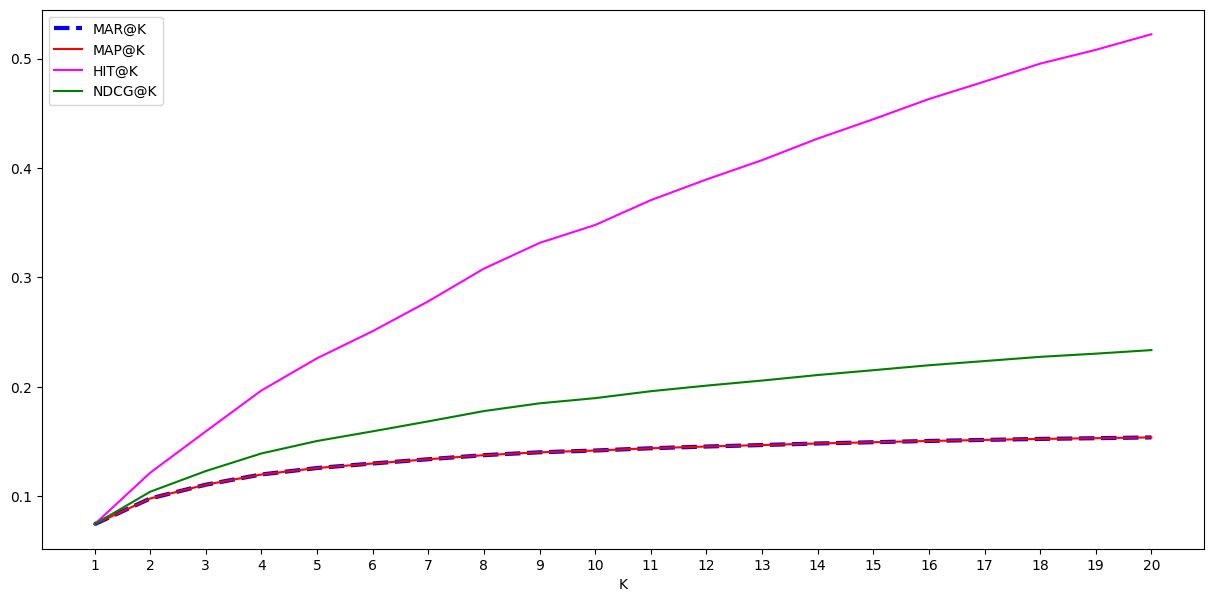

In [238]:
plt.figure(figsize=(15, 7))
plt.plot(mark_df['K'], mark_df['mark'],color = 'blue', ls = '--', lw = 3, label = 'MAR@K')
plt.plot(mapk_df['K'], mapk_df['mapk'], color = 'red', label = 'MAP@K')
plt.plot(hit_df['K'], hit_df['hit'], color = 'magenta', label = 'HIT@K')
plt.plot(ndcg_df['K'], ndcg_df['ndcg'], color = 'green', label = 'NDCG@K')

plt.xticks(index)
plt.legend()
plt.xlabel('K')

plt.show()